# Tarea 2 Procesamiento de Lenguaje Natural

Estudiante: Sofía Vits<br>
Profesora: María Paz Raveau<br>
Fecha entrega: 3 de agosto 2025

### Introducción

En este trabajo se diagnosticarán los tópicos presentes en un subset de la base de datos "El Chile que Queremos", utilizando topic modeling, más específicamente Latent Dirichlet Allocation (LDA) y clustering (K-means).

### Desarrollo

#### Carga de librerías

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
import math
import nltk
import string

remove_punct_map = dict.fromkeys(map(ord, string.punctuation))
pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)
from itertools import compress
from nltk import word_tokenize
import re

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
import stanza
nlp = stanza.Pipeline(lang='es', processors='tokenize,mwt,pos,lemma')

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json


INFO:stanza:Loading these models for language: es (Spanish):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


Otras librerías utilizadas en la tarea 2:

spacy: [Fuente](https://spacy.io/)

Descripción breve: spaCy es una librería de procesamiento de lenguaje natural, diseñada para su uso en producción (no está creada para propósitos de investigación), facilitando el procesamiento de grandes volúmenes de texto. En este trabajo se usará para filtrar sustantivos y adjetivos presentes en la base de datos "El Chile que Queremos".

#### Carga de archivo y pre-procesamiento

In [5]:
ecqq = pd.read_csv('ecqq.csv', sep='delimiter', on_bad_lines='warn') # usa separador regex

/tmp/ipython-input-1315084596.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ecqq = pd.read_csv('ecqq.csv', sep='delimiter', on_bad_lines='warn')


In [6]:
ecqq.shape

(10203, 1)

In [7]:
ecqq.head()

,P2_1_B
0,0\tse necesitan pensiones dignas a los adultos...
1,"1\tel acceso a la salud sea de calidad, con di..."
2,"2\t""conprender que el trabajo es una """"activid..."
3,"junto con ello, asimilar a trabajadores honora..."
4,"3\t""- más especialistas en los consultorios, s..."


In [8]:
ecqq.shape

(10203, 1)

In [9]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

En este paso se lematizará la base de datos.

In [10]:
def lemmatizer(text):
  doc = nlp(text)
  return ' '.join([x.lemma for x in doc.sentences[0].words])

In [11]:
len(set(word_tokenize(' '.join(ecqq['P2_1_B'].to_list()))))

13458

In [12]:
ecqq['lemma'] = [lemmatizer(x) for x in ecqq['P2_1_B']]

In [13]:
len(set(word_tokenize(' '.join(ecqq.lemma.to_list()))))

9963

In [14]:
ecqq['lemma'] = ecqq['lemma'].str.lower()
len(set(word_tokenize(' '.join(ecqq.lemma.to_list()))))

9934

In [15]:
ecqq['lemma'] = ecqq['lemma'].str.translate(str.maketrans(' ', ' ', string.punctuation))
ecqq['lemma'] = ecqq['lemma'].str.translate(str.maketrans(' ', ' ', string.digits))
len(set(word_tokenize(' '.join(ecqq.lemma.to_list()))))

4854

Limpia caracteres irrelevantes para el análisis del corpus.

In [16]:
ecqq['lemma'] = ecqq['lemma'].str.replace('\n',' ')
ecqq['lemma'] = ecqq['lemma'].str.strip()
ecqq['lemma'] = ecqq['lemma'].str.replace('\d+', '')
ecqq['lemma'] = ecqq['lemma'].str.replace("°", "")
ecqq['lemma'] = ecqq['lemma'].str.replace('"-', "")
ecqq['lemma'] = ecqq['lemma'].str.replace('"', "")
ecqq['lemma'] = ecqq['lemma'].str.replace('•', "")
len(set(word_tokenize(' '.join(ecqq.lemma.to_list()))))

4848

In [17]:
ecqq = ecqq[[len(x.split( )) >2  for x in ecqq.lemma]]
ecqq = ecqq.reset_index(drop=True)
len(set(word_tokenize(' '.join(ecqq.lemma.to_list()))))

4801

In [18]:
ecqq.shape

(9380, 2)

In [19]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Se eliminan stopwords del corpus.

In [20]:
from nltk.corpus import stopwords
esp_stop = stopwords.words('spanish')
from nltk.corpus import stopwords
esp_stop = stopwords.words('spanish')
esp_stop = esp_stop + ['deber', 'concepto', 'través']
esp_stop.remove('estado')
esp_stop.remove('estados')

Se eliminan palabras que no sean sustantivos ni adjetivos, ya que en pruebas realizadas para determinar la cantidad de tópicos se confirmó que preposiciones, adverbios y verbos resultaron ser ruido y no aportaban información suficiente.

In [21]:
import spacy
# Cargar el modelo de español
nlp = spacy.load('es_core_news_sm')

In [22]:
# Función para filtrar sustantivos y adjetivos usando spaCy
def filtrar_sustantivos_adjetivos(texto):
    # La variable 'texto' es una cadena de texto, así que la procesamos directamente.
    doc = nlp(texto)

    # Nos quedamos solo con las palabras que son sustantivos o adjetivos
    palabras_filtradas = [token.text for token in doc if token.pos_ in ['NOUN', 'ADJ']]

    # Devolvemos el resultado como una sola cadena de texto
    return ' '.join(palabras_filtradas)

In [23]:
# 1. Filtramos los textos iniciales que tengan más de 2 palabras
ecqq = ecqq[ecqq['lemma'].apply(len) > 2].copy()

# 2. Aplicamos la nueva función a la columna 'lemma'
ecqq['lemma'] = ecqq['lemma'].apply(filtrar_sustantivos_adjetivos)

# 3. Limpiamos las filas que quedaron vacías y reiniciamos el índice
ecqq = ecqq[ecqq['lemma'] != '']
ecqq = ecqq.reset_index(drop=True)

# Muestra el resultado
print(ecqq.head())

                                              P2_1_B  \
0  0\tse necesitan pensiones dignas a los adultos...   
1  1\tel acceso a la salud sea de calidad, con di...   
2  2\t"conprender que el trabajo es una ""activid...   
3  junto con ello, asimilar a trabajadores honora...   
4  3\t"- más especialistas en los consultorios, s...   

                                               lemma  
0         pensión digno adulto mayor costo vida alto  
1  acceso salud calidad diagnostico confianza con...  
2  trabajo actividad lugar físico partir incorpor...  
3  junto trabajador honorario cto indefinido trab...  
4  especialista consultorio escaso hora espera in...  


In [24]:
ecqq.to_csv('ecqq_preprocesado.csv', index=False) # guarda base de datos preprocesada

#### Creación de bigramas

In [2]:
ecqq = pd.read_csv('ecqq_preprocesado.csv')

In [3]:
import gensim
from gensim import corpora
from gensim import models

La sección para tokenizar y crear bigramas se basa en este [tutorial]( https://radimrehurek.com/gensim_3.8.3/auto_examples/tutorials/run_lda.html).

In [4]:
# Tokeniza los documentos
from nltk.tokenize import RegexpTokenizer

# Divide los documentos en tokens
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(ecqq.lemma)):
    ecqq.lemma[idx] = ecqq.lemma[idx].lower()  # Convierte a minúsculas.
    ecqq.lemma[idx] = tokenizer.tokenize(ecqq.lemma[idx])  # Divide en palabras.

# Elimina números, pero no palabras que contienen números
corpus = [[token for token in doc if not token.isnumeric()] for doc in ecqq.lemma]

# Elimina palabras
corpus = [[token for token in doc if len(token) > 1] for doc in corpus]

/tmp/ipython-input-1740608333.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ecqq.lemma[idx] = ecqq.lemma[idx].lower()  # Convert to lowercase.
/tmp/ipython-input-1740608333.py:8: FutureWarning: ChainedAssignmentError: behaviour will ch

In [5]:
corpus

[['pensión', 'digno', 'adulto', 'mayor', 'costo', 'vida', 'alto'],
 ['acceso', 'salud', 'calidad', 'diagnostico', 'confianza', 'confianza'],
 ['trabajo',
  'actividad',
  'lugar',
  'físico',
  'partir',
  'incorporación',
  'flexibilidad',
  'laboral',
  'mayor',
  'motivación'],
 ['junto',
  'trabajador',
  'honorario',
  'cto',
  'indefinido',
  'trabajador',
  'categori'],
 ['especialista', 'consultorio', 'escaso', 'hora', 'espera', 'interminable'],
 ['exámen', 'urgencia', 'igual', 'atención', 'especialista', 'mes', 'año'],
 ['atención', 'médico', 'equipo', 'malo', 'calidad', 'irrespetuoso'],
 ['ojo', 'educación', 'joven', 'capaz', 'país', 'uno', 'vez'],
 ['malo', 'atención'],
 ['gente', 'vida', 'migaja', 'dinero'],
 ['falta', 'especialistas', 'medico'],
 ['falta', 'inversión', 'área'],
 ['lista', 'espera', 'enfermo'],
 ['sistema', 'espera', 'eficiente'],
 ['mal', 'trato', 'personal'],
 ['sueldo', 'inconveniente', 'forma', 'mensual', 'necesidad', 'persona'],
 ['demora', 'interconsu

In [6]:
# Computa bigramas.
from gensim.models import Phrases

# Agrega bigramas a documentos (sólo los que aparecen veinte veces o más)
bigram = Phrases(corpus, min_count=20)
for idx in range(len(corpus)):
    for token in bigram[corpus[idx]]:
        if '_' in token:
            # Tokenes agregado si es un bigrama.
            corpus[idx].append(token)


In [7]:
corpus

[['pensión',
  'digno',
  'adulto',
  'mayor',
  'costo',
  'vida',
  'alto',
  'adulto_mayor'],
 ['acceso', 'salud', 'calidad', 'diagnostico', 'confianza', 'confianza'],
 ['trabajo',
  'actividad',
  'lugar',
  'físico',
  'partir',
  'incorporación',
  'flexibilidad',
  'laboral',
  'mayor',
  'motivación'],
 ['junto',
  'trabajador',
  'honorario',
  'cto',
  'indefinido',
  'trabajador',
  'categori'],
 ['especialista', 'consultorio', 'escaso', 'hora', 'espera', 'interminable'],
 ['exámen', 'urgencia', 'igual', 'atención', 'especialista', 'mes', 'año'],
 ['atención', 'médico', 'equipo', 'malo', 'calidad', 'irrespetuoso'],
 ['ojo', 'educación', 'joven', 'capaz', 'país', 'uno', 'vez'],
 ['malo', 'atención'],
 ['gente', 'vida', 'migaja', 'dinero'],
 ['falta', 'especialistas', 'medico'],
 ['falta', 'inversión', 'área'],
 ['lista', 'espera', 'enfermo', 'lista_espera'],
 ['sistema', 'espera', 'eficiente'],
 ['mal', 'trato', 'personal'],
 ['sueldo', 'inconveniente', 'forma', 'mensual', 'n

In [8]:
dict_corpus = corpora.Dictionary(corpus)

In [9]:
# Elimina tokens comunes y poco frecuentes
from gensim.corpora import Dictionary

# Remueve tokens que aparecen en menos de 20 documents, o en más de 50% de los documentos.
dict_corpus.filter_extremes(no_below=20, no_above=0.5)

Este paso para filtrar tokens permite eliminar palabras mal escritas, dado que no aparecen frecuentemente en los documentos.

In [10]:
# Bag-of-words del documento
dtm_gensim = [dict_corpus.doc2bow(i) for i in corpus]

In [11]:
print('Number of unique tokens: %d' % len(dict_corpus))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 319
Number of documents: 9267


#### Diagnóstico de tópicos

Primero se realizará el diagnóstico de tópicos de forma tentativa considerando seis tópicos inicialmente.

In [12]:
lda_gensim = gensim.models.ldamodel.LdaModel

In [13]:
ldamodel_gensim = lda_gensim(dtm_gensim,num_topics = 6,id2word=dict_corpus, random_state=0, iterations=50, passes=10)

In [14]:
ldamodel_gensim.print_topics(num_words=10)

[(0,
  '0.157*"salud" + 0.105*"mayor" + 0.049*"adulto" + 0.046*"adulto_mayor" + 0.043*"acceso" + 0.043*"público" + 0.034*"calidad" + 0.034*"social" + 0.030*"privado" + 0.022*"agua"'),
 (1,
  '0.120*"atención" + 0.065*"medicamento" + 0.055*"calidad" + 0.053*"profesional" + 0.053*"salud" + 0.052*"mejor" + 0.047*"malo" + 0.041*"hospital" + 0.036*"falta" + 0.031*"buen"'),
 (2,
  '0.127*"educación" + 0.066*"falta" + 0.046*"necesidad" + 0.039*"calidad" + 0.039*"recurso" + 0.036*"derecho" + 0.026*"especialista" + 0.025*"básico" + 0.025*"sector" + 0.024*"país"'),
 (3,
  '0.123*"sistema" + 0.118*"pensión" + 0.060*"sueldo" + 0.052*"vida" + 0.039*"digno" + 0.027*"persona" + 0.025*"enfermedad" + 0.024*"edad" + 0.019*"mínimo" + 0.018*"cambio"'),
 (4,
  '0.175*"espera" + 0.127*"lista" + 0.119*"lista_espera" + 0.059*"país" + 0.057*"tiempo" + 0.038*"largo" + 0.032*"ley" + 0.025*"tiempo_espera" + 0.021*"político" + 0.017*"atención"'),
 (5,
  '0.102*"especialista" + 0.097*"hora" + 0.062*"persona" + 0.04

Los temas que se observan serían salud, pensiones y educación.

Tópico 0 sería acceso a la salud de adultos mayores.<br>
Tópico 1 sería problemas de atención en salud.<br>
Tópico 2 sería mejorar calidad de educación.<br>
Tópico 3 sería mejorar sueldos y pensiones.<br>
Tópico 4 sería problemas con listas de espera.<br>
Tópico 5 sería atención médica.


In [15]:
ldamodel_gensim.get_topics().shape

(6, 319)

In [16]:
ldamodel_gensim.get_topics().sum(axis=1)

array([0.99999994, 0.9999999 , 0.9999999 , 1.        , 1.        ,
       1.        ], dtype=float32)

In [17]:
df_topic_term = pd.DataFrame(ldamodel_gensim.get_topics(), columns=ldamodel_gensim.id2word.values(), index=[f'topic{i}' for i in range(ldamodel_gensim.num_topics)])

In [18]:
df_topic_term.head()

,adulto,adulto_mayor,alto,costo,digno,mayor,pensión,vida,acceso,calidad,salud,laboral,lugar,trabajo,trabajador,consultorio,escaso,especialista,espera,hora,atención,año,exámen,igual,mes,urgencia,malo,médico,educación,joven,país,vez,dinero,gente,falta,medico,inversión,área,enfermo,lista,lista_espera,eficiente,sistema,mal,personal,trato,forma,necesidad,persona,sueldo,demora,general,posta,prioridad,público,recurso,rural,sector,sector_rural,servicio,enfermedad,constitución,necesario,nuevo,relación,nivel,profesional,privado,urgente,alumno,cara,centro,zona,realidad,igualdad,política,valor,hospital,día,estudiante,respeto,agua,caro,demanda,cobertura,oportunidad,institución,vocación,administración,gasto,auge,social,apoyo,deber,discapacidad,estado,fondo,extranjero,politico,justicia,robo,medicamento,particular,suficiente,libre,seguro,universal,operación,remedio,adecuado,vivienda,mínimo,ser,sueldo_mínimo,gratuidad,población,baja,pensión_baja,desigualdad,tiempo,tiempo_espera,programa,familia,proceso,hogar,región,formación,calle,orden,beneficio,económico,ingreso,mejor,pobre,parte,actual,ayuda,caso,ejemplo,participante,situación,importante,indigno,fin,beca,precario,largo,basico,ciudadanía,derecho,cambio,manera,real,fundamental,plata,afp,información,bajo,comuna,clase,clase_medio,medio,pobreza,insumo,infraestructura,buen,hijo,niño,problema,distinto,cuanto,poder,ganancia,injusto,monto,solidario,momento,alcance,presupuesto,especialidad,difícil,pequeño,fila,casa,chileno,salario,reforma,principal,número,edad,superior,opción,colegio,educacional,establecimiento,seguridad,jubilación,lucro,respecto,subsidio,gratuito,deficiente,equitativo,aumento,jubilado,expedito,fuerza,acuerdo,mayoría,igualitario,justo,mano,solución,equidad,rico,integral,oportuno,paciente,cargo,base,cosa,entrega,rapido,vejez,tema,condición,accesible,carabinero,inclusión,ley,básico,necesidad_básico,grande,gestión,rápido,interés,posible,primario,uso,profesor,fiscalización,posibilidad,diferencia,examen,político,discriminación,autoridad,decisión,universitario,mejora,control,empatía,sociedad,pensionado,expectativa,antiguo,prestación,diferente,psu,cesfam,dotación,empresa,plan,gobierno,extremo,brecha,desarrollo,usuario,futuro,compromiso,plazo,dignidad,precio,tratamiento,accesibilidad,burocracia,distribución,gran,tercero,tercero_edad,farmacia,negocio,pueblo,natural,través,menor,primero,delincuencia,consumo,regulación,transporte,alto_costo,deuda,ciudadano,debido,vulnerable,doctor,funcionario,familiar,humano,mental,modelo,preocupación,ahorro,horario,lento,cantidad,grupo,mujer,capacidad,elevado,municipal,pago,herramienta,disponibilidad,violencia,padre,especial,pésimo
topic0,0.049060,0.045771,0.000031,0.000031,0.010859,0.104879,0.000031,0.000264,0.043410,0.034464,0.156828,0.000054,0.000031,0.006199,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031,0.000045,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031,0.000038,0.000031,0.000031,0.000041,0.000031,0.000031,0.003037,0.007456,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031,0.000140,0.003214,0.000031,0.000031,0.002801,0.000031,0.011910,0.043166,0.013873,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031,0.000985,0.000031,0.000031,0.030322,0.000031,0.000031,0.003366,0.012704,0.000031,0.006036,0.000031,0.005877,0.000031,0.000031,0.000031,0.000031,0.000031,0.022263,0.000031,0.006857,0.002487,0.000031,0.002302,0.000031,0.000031,0.000031,0.000031,0.033781,0.000031,0.000031,0.000031,0.000031,0.000031,0.006544,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031,0.003810,0.000031,0.000031,0.000031,0.000031,0.009030,0.000031,0.000031,0.000031,0.001006,0.000031,0.000031,0.000031,0.013583,0.000031,0.000031,0.000031,0.000031,0.000031,0.005233,0.000031,0.000031,0.001608,0.000031,0.002134,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031,0.003668,0.002489,0.003181,0.001192,0.000031,0.009359,0.000031,0.000031,0.001957,0.003140,0.000031,0.000031,0.000031,0.0100

In [19]:
df_topic_term.loc['topic0'].sort_values(ascending=False)

,topic0
salud,0.156828
mayor,0.104879
adulto,0.049060
adulto_mayor,0.045771
acceso,0.043410
público,0.043166
calidad,0.034464
social,0.033781
privado,0.030322
agua,0.022263


In [20]:
df_topic_term.loc['topic1'].sort_values(ascending=False)

,topic1
atención,0.120451
medicamento,0.064554
calidad,0.055315
profesional,0.052891
salud,0.052734
mejor,0.051670
malo,0.047435
hospital,0.041097
falta,0.035623
buen,0.030894


In [21]:
df_topic_term.loc['topic2'].sort_values(ascending=False)

,topic2
educación,0.127317
falta,0.065769
necesidad,0.045985
calidad,0.039161
recurso,0.038832
derecho,0.035909
especialista,0.025841
básico,0.025114
sector,0.024569
país,0.024291


In [22]:
df_topic_term.loc['topic3'].sort_values(ascending=False)

,topic3
sistema,0.123257
pensión,0.117779
sueldo,0.059938
vida,0.052133
digno,0.038988
persona,0.026818
enfermedad,0.025210
edad,0.024341
mínimo,0.019259
cambio,0.017620


In [23]:
df_topic_term.loc['topic4'].sort_values(ascending=False)

,topic4
espera,0.175003
lista,0.127031
lista_espera,0.119247
país,0.059287
tiempo,0.056638
largo,0.038266
ley,0.031926
tiempo_espera,0.024965
político,0.021116
atención,0.017422


In [24]:
df_topic_term.loc['topic5'].sort_values(ascending=False)

,topic5
especialista,0.101587
hora,0.096565
persona,0.062171
médico,0.046308
estado,0.041639
gente,0.041233
medico,0.039969
atención,0.036709
año,0.028658
deber,0.024711


In [25]:
ldamodel_gensim[dtm_gensim][5]

[(0, 0.020833937),
 (1, 0.20667471),
 (2, 0.020847723),
 (3, 0.15585023),
 (4, 0.020930033),
 (5, 0.5748634)]

Observando los resultados, ellos implican que en los tópicos 1, 3 y 5 tienen mayor prevalencia que los tópicos 0, 2 y 4.

In [26]:
cont = 0
for i in ldamodel_gensim[dtm_gensim]:
  print('doc ',cont , ': ',i)
  cont +=1

Se truncaron las últimas líneas 5000 del resultado de transmisión.
doc  4267 :  [(0, 0.055555843), (1, 0.7219278), (2, 0.055555835), (3, 0.055555835), (4, 0.05574093), (5, 0.055663757)]
doc  4268 :  [(0, 0.05555697), (1, 0.055556968), (2, 0.055556975), (3, 0.38886106), (4, 0.38891107), (5, 0.055556986)]
doc  4269 :  [(0, 0.04177507), (1, 0.041667745), (2, 0.041667756), (3, 0.54153824), (4, 0.29168344), (5, 0.04166776)]
doc  4270 :  [(0, 0.05610672), (1, 0.38767374), (2, 0.05622466), (3, 0.055853676), (4, 0.05555615), (5, 0.38858506)]
doc  4271 :  [(0, 0.042277057), (1, 0.50209117), (2, 0.041687742), (3, 0.041667826), (4, 0.3305235), (5, 0.0417527)]
doc  4272 :  [(0, 0.05572869), (1, 0.055558283), (2, 0.3889153), (3, 0.38868105), (4, 0.05555836), (5, 0.055558316)]
doc  4273 :  [(0, 0.8321938), (1, 0.033587877), (2, 0.03384347), (3, 0.03370772), (4, 0.033333566), (5, 0.033333562)]
doc  4274 :  [(0, 0.055556327), (1, 0.38889754), (2, 0.055556327), (3, 0.055556327), (4, 0.055556342), (5, 0

In [27]:
# documentos representativos de un tópico dado

def get_max(doc):
        idx,l = zip(*doc)
        return idx[np.argmax(l)] , l[np.argmax(l)]

doc_rep = [get_max(doc) for doc in ldamodel_gensim[dtm_gensim]]
doc_rep = pd.DataFrame(doc_rep, columns =['tópico', 'prop'])
doc_rep['doc'] = doc_rep.index

In [28]:
len(doc_rep)

9267

In [29]:
doc_rep[doc_rep.tópico==0].sort_values('prop',ascending=False).head()

,tópico,prop,doc
4157,0,0.895753,4157
3342,0,0.894239,3342
3167,0,0.880952,3167
6646,0,0.880858,6646
4577,0,0.880758,4577


Ver palabras FREX

In [30]:
w=0.5    # 0 equivale a beta
import scipy as sp
from scipy.special import logsumexp

def ecdf(arr):
    """Calculate the ECDF values for all elements in a 1D array.  empirical cumulative ditribution function """
    return sp.stats.rankdata(arr, method='max') / arr.size


log_beta = np.log(ldamodel_gensim.get_topics())
log_exclusivity = log_beta - logsumexp(log_beta, axis=0)

exclusivity_ecdf = np.apply_along_axis(ecdf, 1, log_exclusivity)
freq_ecdf = np.apply_along_axis(ecdf, 1, log_beta)
out_frex = 1. / (w / exclusivity_ecdf + (1 - w) / freq_ecdf)

In [31]:
out_frex

array([[0.99529534, 0.99216053, 0.17361948, ..., 0.86908978, 0.81180329,
        0.4700403 ],
       [0.08730741, 0.09185331, 0.97329113, ..., 0.16655101, 0.52338486,
        0.38221389],
       [0.08060905, 0.0862069 , 0.1353662 , ..., 0.57415647, 0.79265739,
        0.33154906],
       [0.1043293 , 0.11860312, 0.22168968, ..., 0.63053743, 0.31696273,
        0.43345683],
       [0.08215328, 0.09404389, 0.20857944, ..., 0.45799281, 0.38733585,
        0.92914726],
       [0.07087365, 0.07916897, 0.12539185, ..., 0.66747612, 0.65215732,
        0.45264368]])

In [32]:
df_topic_frex = pd.DataFrame(out_frex, columns=ldamodel_gensim.id2word.values(), index=[f'topic{i}' for i in range(ldamodel_gensim.num_topics)])

In [33]:
df_topic_frex.loc['topic0'].sort_values(ascending=False)

,topic0
mayor,0.998430
adulto,0.995295
adulto_mayor,0.992161
privado,0.982696
agua,0.979561
clase,0.976426
medio,0.973291
desigualdad,0.968561
centro,0.965426
chileno,0.960751


Según las palabras FREX el tópico 0 no se podría definir adecuadamente.

In [34]:
df_topic_frex.loc['topic1'].sort_values(ascending=False)

,topic1
medicamento,0.998430
profesional,0.993721
mejor,0.987451
malo,0.987421
buen,0.979561
costo,0.976426
alto,0.973291
personal,0.968561
hospital,0.965354
trato,0.963825


Tópico 1 sería mala calidad de la atención en salud.

In [35]:
df_topic_frex.loc['topic2'].sort_values(ascending=False)

,topic2
educación,1.000000
básico,0.987371
sector,0.984236
oportunidad,0.979501
gratuito,0.974831
familia,0.974760
igualdad,0.970095
colegio,0.963743
económico,0.960608
base,0.957472


El tópico 2 sería derecho a la educación según las palabras FREX.

In [36]:
df_topic_frex.loc['topic3'].sort_values(ascending=False)

,topic3
sistema,1.000000
pensión,0.996865
sueldo,0.993730
enfermedad,0.985871
edad,0.982736
mínimo,0.979601
aumento,0.973291
jubilación,0.970156
baja,0.967021
actual,0.963886


El tópico 3 sería mejora de sueldos y pensiones.

In [37]:
df_topic_frex.loc['topic4'].sort_values(ascending=False)

,topic4
espera,1.000000
lista,0.996865
lista_espera,0.993730
tiempo,0.989026
largo,0.985891
ley,0.982756
tiempo_espera,0.979621
político,0.976487
poder,0.971777
control,0.967062


El tópico 4 mexcla temas de salud y política. Esto es poco claro.

In [38]:
df_topic_frex.loc['topic5'].sort_values(ascending=False)

,topic5
hora,0.998430
estado,0.992141
medico,0.987421
gente,0.985891
deber,0.981101
acuerdo,0.974831
región,0.971696
pueblo,0.966960
sociedad,0.963825
discapacidad,0.960690


El tópico 5 se referiría a problemas varios, incluyendo salud y pobreza.

Procedemos a realizar el diagnóstico de tópicos

In [39]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel_gensim, texts=corpus, dictionary=dict_corpus, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Compute Perplexity
print('\nPerplexity: ', ldamodel_gensim.log_perplexity(dtm_gensim))  # a measure of how good the model is. lower the better.


Coherence Score:  0.3151304726838814

Perplexity:  -5.218474578668154


In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(corpus, train_size=0.9, test_size=0.1, random_state=1)

dict_corpus_train = corpora.Dictionary(X_train)
dtm_gensim_train = [dict_corpus_train.doc2bow(i) for i in X_train]

dict_corpus_test = corpora.Dictionary(X_test)
dtm_gensim_test = [dict_corpus_test.doc2bow(i) for i in X_test]

n_topics = range(1,20)

coherence_lda = []
perplexity = []
for nr_topics in n_topics:
    ldamodel2 = gensim.models.LdaModel(dtm_gensim_train, id2word=dict_corpus_train, num_topics=nr_topics, random_state=42, iterations=50, passes=20)
    perplexity.append(2**(-1*ldamodel2.log_perplexity(dtm_gensim_test)))

    ldamodel3= lda_gensim(dtm_gensim,num_topics = nr_topics ,id2word=dict_corpus, random_state=0, iterations=50, passes=20)
    coherence_model_lda = CoherenceModel(model=ldamodel3, texts=corpus, dictionary=dict_corpus, coherence='c_v')
    coherence_lda.append(coherence_model_lda.get_coherence())

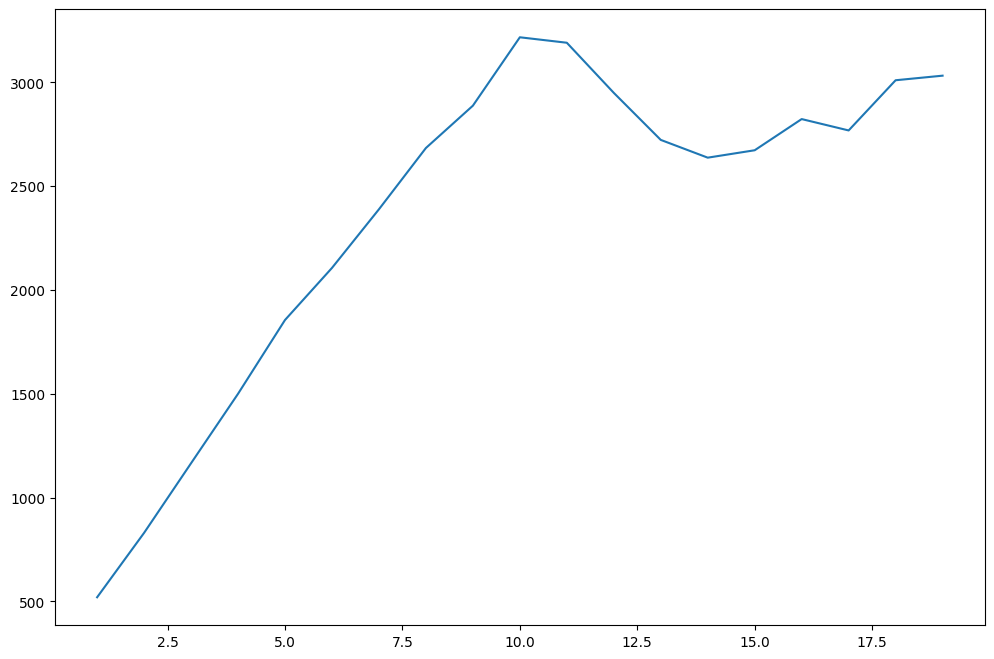

In [41]:
plt.figure(figsize=(12, 8))
plt.plot(n_topics, perplexity)

El valor de perplexity es menor a medida que se reduce la cantidad de tópicos. Esto apoyaría la hipótesis de que en realidad existen menos de seis tópicos en la base de datos.

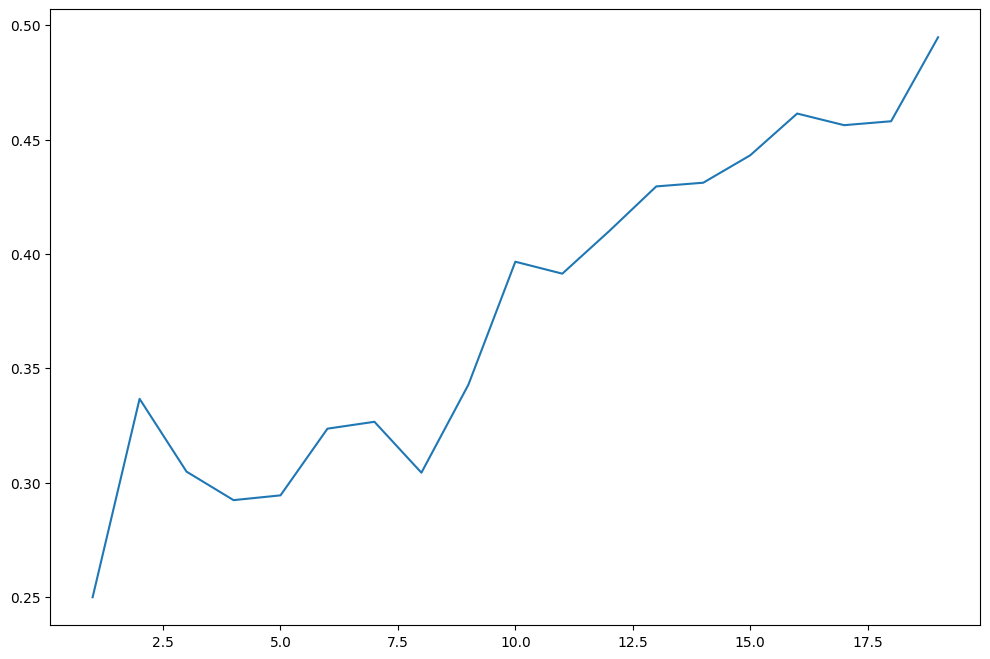

In [42]:
plt.figure(figsize=(12, 8))
plt.plot(n_topics, coherence_lda)

La coherencia llega a un peak en dos tópicos.

In [43]:
coherence_lda

[0.2498597796316008,
 0.33663349492116024,
 0.30479302147598136,
 0.2923355859250622,
 0.2944252043251991,
 0.3235903422006336,
 0.32659485209450606,
 0.30433866056025427,
 0.34278587561286533,
 0.3965908352711854,
 0.3913638490306877,
 0.4100156919302926,
 0.42951612046151677,
 0.4311280977965919,
 0.443113053273169,
 0.4613764765894096,
 0.45629685490832506,
 0.4580107949058324,
 0.49472882827214354]

Considerando tanto los valores de coherencia como perplexity, se asume que el número óptimo de tópicos es dos.

#### LDA considerando dos tópicos

In [44]:
ldamodel_gensim = lda_gensim(dtm_gensim,num_topics = 2,id2word=dict_corpus, random_state=0, iterations= 50, passes=100)

In [45]:
ldamodel_gensim.print_topics(num_words=10)

[(0,
  '0.042*"educación" + 0.041*"sistema" + 0.040*"pensión" + 0.037*"mayor" + 0.033*"persona" + 0.020*"país" + 0.020*"necesidad" + 0.019*"sueldo" + 0.019*"digno" + 0.018*"vida"'),
 (1,
  '0.085*"salud" + 0.071*"atención" + 0.053*"calidad" + 0.041*"especialista" + 0.041*"espera" + 0.039*"falta" + 0.030*"público" + 0.029*"hora" + 0.029*"lista" + 0.029*"acceso"')]

Tópico 0 es sobre el sistema de educación, pensiones y sueldos dignos.
Tópico 1 es sobre la calidad de la atención en salud.

In [46]:
ldamodel_gensim.get_topics().shape

(2, 319)

In [47]:
ldamodel_gensim.get_topics().sum(axis=1)

array([0.99999994, 1.0000001 ], dtype=float32)

In [48]:
df_topic_term = pd.DataFrame(ldamodel_gensim.get_topics(), columns=ldamodel_gensim.id2word.values(), index=[f'topic{i}' for i in range(ldamodel_gensim.num_topics)])

In [49]:
df_topic_term.head()

,adulto,adulto_mayor,alto,costo,digno,mayor,pensión,vida,acceso,calidad,salud,laboral,lugar,trabajo,trabajador,consultorio,escaso,especialista,espera,hora,atención,año,exámen,igual,mes,urgencia,malo,médico,educación,joven,país,vez,dinero,gente,falta,medico,inversión,área,enfermo,lista,lista_espera,eficiente,sistema,mal,personal,trato,forma,necesidad,persona,sueldo,demora,general,posta,prioridad,público,recurso,rural,sector,sector_rural,servicio,enfermedad,constitución,necesario,nuevo,relación,nivel,profesional,privado,urgente,alumno,cara,centro,zona,realidad,igualdad,política,valor,hospital,día,estudiante,respeto,agua,caro,demanda,cobertura,oportunidad,institución,vocación,administración,gasto,auge,social,apoyo,deber,discapacidad,estado,fondo,extranjero,politico,justicia,robo,medicamento,particular,suficiente,libre,seguro,universal,operación,remedio,adecuado,vivienda,mínimo,ser,sueldo_mínimo,gratuidad,población,baja,pensión_baja,desigualdad,tiempo,tiempo_espera,programa,familia,proceso,hogar,región,formación,calle,orden,beneficio,económico,ingreso,mejor,pobre,parte,actual,ayuda,caso,ejemplo,participante,situación,importante,indigno,fin,beca,precario,largo,basico,ciudadanía,derecho,cambio,manera,real,fundamental,plata,afp,información,bajo,comuna,clase,clase_medio,medio,pobreza,insumo,infraestructura,buen,hijo,niño,problema,distinto,cuanto,poder,ganancia,injusto,monto,solidario,momento,alcance,presupuesto,especialidad,difícil,pequeño,fila,casa,chileno,salario,reforma,principal,número,edad,superior,opción,colegio,educacional,establecimiento,seguridad,jubilación,lucro,respecto,subsidio,gratuito,deficiente,equitativo,aumento,jubilado,expedito,fuerza,acuerdo,mayoría,igualitario,justo,mano,solución,equidad,rico,integral,oportuno,paciente,cargo,base,cosa,entrega,rapido,vejez,tema,condición,accesible,carabinero,inclusión,ley,básico,necesidad_básico,grande,gestión,rápido,interés,posible,primario,uso,profesor,fiscalización,posibilidad,diferencia,examen,político,discriminación,autoridad,decisión,universitario,mejora,control,empatía,sociedad,pensionado,expectativa,antiguo,prestación,diferente,psu,cesfam,dotación,empresa,plan,gobierno,extremo,brecha,desarrollo,usuario,futuro,compromiso,plazo,dignidad,precio,tratamiento,accesibilidad,burocracia,distribución,gran,tercero,tercero_edad,farmacia,negocio,pueblo,natural,través,menor,primero,delincuencia,consumo,regulación,transporte,alto_costo,deuda,ciudadano,debido,vulnerable,doctor,funcionario,familiar,humano,mental,modelo,preocupación,ahorro,horario,lento,cantidad,grupo,mujer,capacidad,elevado,municipal,pago,herramienta,disponibilidad,violencia,padre,especial,pésimo
topic0,0.017168,0.015971,0.000051,0.000051,0.019404,0.036894,0.039691,0.017632,0.000063,0.000055,0.000046,0.005532,0.002766,0.010887,0.002953,0.000035,0.000930,0.000035,0.000034,0.000037,0.000037,0.011465,0.000034,0.00458,0.002437,0.000037,0.000040,0.000036,0.041796,0.003110,0.020261,0.002676,0.007444,0.011549,0.000039,0.000035,0.000047,0.000039,0.000042,0.000034,0.000034,0.000057,0.040557,0.000053,0.000045,0.000043,0.005105,0.020027,0.033225,0.01942,0.000035,0.003299,0.000034,0.004300,0.000042,0.017620,0.000041,0.000046,0.000035,0.000043,0.000043,0.001880,0.006453,0.004883,0.001863,0.004694,0.000037,0.000057,0.002344,0.000158,0.001035,0.000037,0.000037,0.002466,0.006581,0.002723,0.001041,0.000036,0.003577,0.001517,0.003422,0.007883,0.000038,0.002485,0.000039,0.007807,0.002160,0.000038,0.001285,0.003029,0.000035,0.013507,0.002419,0.007056,0.003414,0.011922,0.004646,0.002148,0.001835,0.002129,0.001315,0.000036,0.000046,0.001011,0.001946,0.001362,0.002240,0.000036,0.000037,0.003102,0.004790,0.006794,0.001631,0.004192,0.002527,0.003500,0.005622,0.002953,0.004888,0.000038,0.000034,0.001802,0.006367,0.003180,0.001964,0.000044,0.000046,0.001553,0.002338,0.004520,0.004393,0.005382,0.000063,0.002761,0.004099,0.005381,0.001353,0.002815,0.001601,0.003846,0.002450,0.00328,0.001426,0.002824,0.001629,0.000993,0.000036,0.002742,0.003201,0.015022,

In [50]:
df_topic_term.loc['topic0'].sort_values(ascending=False)

,topic0
educación,0.041796
sistema,0.040557
pensión,0.039691
mayor,0.036894
persona,0.033225
país,0.020261
necesidad,0.020027
sueldo,0.019420
digno,0.019404
vida,0.017632


In [51]:
df_topic_term.loc['topic1'].sort_values(ascending=False)

,topic1
salud,0.084899
atención,0.070649
calidad,0.053275
especialista,0.041020
espera,0.040567
falta,0.039344
público,0.030423
hora,0.029094
lista,0.029061
acceso,0.028757


In [52]:
ldamodel_gensim[dtm_gensim][2]

[(0, 0.8999116), (1, 0.10008839)]

In [53]:
cont = 0
for i in ldamodel_gensim[dtm_gensim]:
  print('doc ',cont , ': ',i)
  cont +=1

Se truncaron las últimas líneas 5000 del resultado de transmisión.
doc  4267 :  [(0, 0.16671176), (1, 0.8332882)]
doc  4268 :  [(0, 0.83312905), (1, 0.16687095)]
doc  4269 :  [(0, 0.8748302), (1, 0.1251698)]
doc  4270 :  [(0, 0.49932957), (1, 0.5006705)]
doc  4271 :  [(0, 0.12514201), (1, 0.874858)]
doc  4272 :  [(0, 0.8324229), (1, 0.16757706)]
doc  4273 :  [(0, 0.49960336), (1, 0.5003966)]
doc  4274 :  [(0, 0.4979194), (1, 0.5020806)]
doc  4275 :  [(0, 0.25012928), (1, 0.7498707)]
doc  4276 :  [(0, 0.31699154), (1, 0.6830085)]
doc  4277 :  [(0, 0.8743979), (1, 0.12560208)]
doc  4278 :  [(0, 0.8749231), (1, 0.12507683)]
doc  4279 :  [(0, 0.74972326), (1, 0.25027668)]
doc  4280 :  [(0, 0.87491256), (1, 0.12508744)]
doc  4281 :  [(0, 0.83292073), (1, 0.16707924)]
doc  4282 :  [(0, 0.87482256), (1, 0.12517744)]
doc  4283 :  [(0, 0.78751326), (1, 0.21248674)]
doc  4284 :  [(0, 0.8331143), (1, 0.16688566)]
doc  4285 :  [(0, 0.7497932), (1, 0.25020686)]
doc  4286 :  [(0, 0.8332557), (1, 0.1

In [ ]:
# documentos representativos de un tópico dado

def get_max(doc):
        idx,l = zip(*doc)
        return idx[np.argmax(l)] , l[np.argmax(l)]

doc_rep = [get_max(doc) for doc in ldamodel_gensim[dtm_gensim]]
doc_rep = pd.DataFrame(doc_rep, columns =['tópico', 'prop'])
doc_rep['doc'] = doc_rep.index

In [54]:
len(doc_rep)

9267

In [55]:
doc_rep[doc_rep.tópico==0].sort_values('prop',ascending=False).head()

,tópico,prop,doc
4157,0,0.895753,4157
3342,0,0.894239,3342
3167,0,0.880952,3167
6646,0,0.880858,6646
4577,0,0.880758,4577


Revisamos palabras FREX

In [56]:
w=0.5    # 0 equivale a beta
import scipy as sp
from scipy.special import logsumexp

def ecdf(arr):
    """Calculate the ECDF values for all elements in a 1D array.  empirical cumulative ditribution function """
    return sp.stats.rankdata(arr, method='max') / arr.size


log_beta = np.log(ldamodel_gensim.get_topics())
log_exclusivity = log_beta - logsumexp(log_beta, axis=0)

exclusivity_ecdf = np.apply_along_axis(ecdf, 1, log_exclusivity)
freq_ecdf = np.apply_along_axis(ecdf, 1, log_beta)
out_frex = 1. / (w / exclusivity_ecdf + (1 - w) / freq_ecdf)

In [57]:
out_frex

array([[0.97019665, 0.96706178, 0.14575463, 0.11320423, 0.96861146,
        0.98587099, 0.99685535, 0.97491155, 0.08558857, 0.03526646,
        0.01222958, 0.89340593, 0.6612043 , 0.94980188, 0.7206624 ,
        0.06631836, 0.33378957, 0.01917758, 0.01074787, 0.04906638,
        0.0060796 , 0.94827327, 0.02904297, 0.83214376, 0.58556322,
        0.10575327, 0.06614874, 0.05780258, 0.99843014, 0.73947984,
        0.98745086, 0.4753995 , 0.92319483, 0.94827327, 0.02859814,
        0.04937304, 0.27227944, 0.16968163, 0.20816933, 0.01316614,
        0.01003135, 0.2836904 , 0.97442772, 0.23340914, 0.1483223 ,
        0.14757656, 0.87459691, 0.98275612, 0.99058569, 0.98273612,
        0.0904726 , 0.67122199, 0.03372608, 0.78124138, 0.05898367,
        0.55159352, 0.14491161, 0.14605828, 0.03979101, 0.09656614,
        0.11367942, 0.56266553, 0.89637635, 0.86988054, 0.50916807,
        0.85578789, 0.05717868, 0.11933845, 0.5595131 , 0.31190435,
        0.33217011, 0.11703239, 0.15698095, 0.65

In [58]:
df_topic_frex = pd.DataFrame(out_frex, columns=ldamodel_gensim.id2word.values(), index=[f'topic{i}' for i in range(ldamodel_gensim.num_topics)])

In [59]:
df_topic_frex.loc['topic0'].sort_values(ascending=False)

,topic0
educación,0.998430
pensión,0.996855
persona,0.990586
país,0.987451
mayor,0.985871
necesidad,0.982756
sueldo,0.982736
vida,0.974912
sistema,0.974428
adulto,0.970197


Analizando las palabras FREX el tópico 0 es derecho a una educación y pensiones mejores.

In [60]:
df_topic_frex.loc['topic1'].sort_values(ascending=False)

,topic1
atención,0.998430
salud,0.998430
especialista,0.990596
espera,0.990586
calidad,0.989006
falta,0.985891
lista,0.978046
hora,0.974912
público,0.974881
medicamento,0.971777


El tópico 1 es mejorar la atención en salud.

In [61]:
df_topic_frex

,adulto,adulto_mayor,alto,costo,digno,mayor,pensión,vida,acceso,calidad,salud,laboral,lugar,trabajo,trabajador,consultorio,escaso,especialista,espera,hora,atención,año,exámen,igual,mes,urgencia,malo,médico,educación,joven,país,vez,dinero,gente,falta,medico,inversión,área,enfermo,lista,lista_espera,eficiente,sistema,mal,personal,trato,forma,necesidad,persona,sueldo,demora,general,posta,prioridad,público,recurso,rural,sector,sector_rural,servicio,enfermedad,constitución,necesario,nuevo,relación,nivel,profesional,privado,urgente,alumno,cara,centro,zona,realidad,igualdad,política,valor,hospital,día,estudiante,respeto,agua,caro,demanda,cobertura,oportunidad,institución,vocación,administración,gasto,auge,social,apoyo,deber,discapacidad,estado,fondo,extranjero,politico,justicia,robo,medicamento,particular,suficiente,libre,seguro,universal,operación,remedio,adecuado,vivienda,mínimo,ser,sueldo_mínimo,gratuidad,población,baja,pensión_baja,desigualdad,tiempo,tiempo_espera,programa,familia,proceso,hogar,región,formación,calle,orden,beneficio,económico,ingreso,mejor,pobre,parte,actual,ayuda,caso,ejemplo,participante,situación,importante,indigno,fin,beca,precario,largo,basico,ciudadanía,derecho,cambio,manera,real,fundamental,plata,afp,información,bajo,comuna,clase,clase_medio,medio,pobreza,insumo,infraestructura,buen,hijo,niño,problema,distinto,cuanto,poder,ganancia,injusto,monto,solidario,momento,alcance,presupuesto,especialidad,difícil,pequeño,fila,casa,chileno,salario,reforma,principal,número,edad,superior,opción,colegio,educacional,establecimiento,seguridad,jubilación,lucro,respecto,subsidio,gratuito,deficiente,equitativo,aumento,jubilado,expedito,fuerza,acuerdo,mayoría,igualitario,justo,mano,solución,equidad,rico,integral,oportuno,paciente,cargo,base,cosa,entrega,rapido,vejez,tema,condición,accesible,carabinero,inclusión,ley,básico,necesidad_básico,grande,gestión,rápido,interés,posible,primario,uso,profesor,fiscalización,posibilidad,diferencia,examen,político,discriminación,autoridad,decisión,universitario,mejora,control,empatía,sociedad,pensionado,expectativa,antiguo,prestación,diferente,psu,cesfam,dotación,empresa,plan,gobierno,extremo,brecha,desarrollo,usuario,futuro,compromiso,plazo,dignidad,precio,tratamiento,accesibilidad,burocracia,distribución,gran,tercero,tercero_edad,farmacia,negocio,pueblo,natural,través,menor,primero,delincuencia,consumo,regulación,transporte,alto_costo,deuda,ciudadano,debido,vulnerable,doctor,funcionario,familiar,humano,mental,modelo,preocupación,ahorro,horario,lento,cantidad,grupo,mujer,capacidad,elevado,municipal,pago,herramienta,disponibilidad,violencia,padre,especial,pésimo
topic0,0.970197,0.967062,0.145755,0.113204,0.968611,0.985871,0.996855,0.974912,0.085589,0.035266,0.01223,0.893406,0.661204,0.949802,0.720662,0.066318,0.333790,0.019178,0.010748,0.049066,0.00608,0.948273,0.029043,0.832144,0.585563,0.105753,0.066149,0.057803,0.998430,0.739480,0.987451,0.475399,0.923195,0.948273,0.028598,0.049373,0.272279,0.169682,0.208169,0.013166,0.010031,0.283690,0.974428,0.233409,0.148322,0.147577,0.874597,0.982756,0.990586,0.982736,0.090473,0.671222,0.033726,0.781241,0.058984,0.551594,0.144912,0.146058,0.039791,0.096566,0.113679,0.562666,0.896376,0.869881,0.509168,0.855788,0.057179,0.119338,0.559513,0.311904,0.332170,0.117032,0.156981,0.659956,0.902647,0.651977,0.330357,0.062696,0.757325,0.444723,0.734756,0.934169,0.132172,0.664813,0.153890,0.929464,0.601081,0.130990,0.355737,0.729923,0.075483,0.960792,0.593113,0.910526,0.781978,0.956103,0.85416,0.562342,0.543653,0.610347,0.396976,0.041037,0.227002,0.338529,0.549938,0.400054,0.510849,0.089125,0.098794,0.701691,0.854206,0.923174,0.467064,0.842514,0.651902,0.757792,0.907456,0.730763,0.874563,0.083196,0.006085,0.449515,0.909080,0.727151,0.578864,0.167004,0.257471,0.458683,0.621590,0.841690,0.822738,0.888690,0.090260,0.675516,0.505891,0.893241,0.407763,0.678593,0.434632,0.817882,0.645220,0.737842,0.418168,0.476190,0.477435,0.333848,0.077241,0.682868,0.749098,0.963927,

Las etiquetas de los tópicos son:

Tópico 0 es derecho a una educación y pensiones mejores, siendo ambos derechos sociales. Las palabras FREX más frecuentes son educación, pensión, adulto mayor, digno, derecho, social. Este tópico menciona sueldo mínimo y trabajo, palabras que están relacionadas con las pensiones ya que el monto de ellas depende del sueldo del trabajador. Además, la educación es propedéuctica de otros derechos sociales. El nivel educativo de las personas incide en la posibilidad de conseguir un trabajo mejor remunerado.

Tópico 1 es mejorar la atención de los servicios de salud, dado que las palabras FREX más frecuentes se refieren a problemas tales como las listas de espera, implica la falta de especialistas, y menciona a los medicamentos. Además, menciona las palabras caro y privado, lo cual implica la necesidad de tener una salud pública de calidad, a muy bajo costo o gratuita, y con menores tiempo de espera para la atención de los pacientes. Esto disminuye el sufrimiento de las personas y mejora su expectativa de vida.

#### Clustering

In [70]:
# Convierte la matriz DTM de gensim a un array compatible con K-means
from scipy.sparse import csc_matrix

scipy_csc_matrix =gensim.matutils.corpus2csc(dtm_gensim)

full_matrix=csc_matrix(scipy_csc_matrix).toarray()


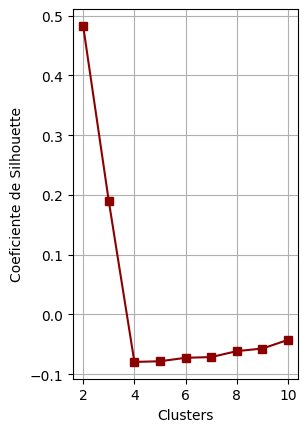

In [71]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
scores_s = []
for i in range(2, 11):
    km = KMeans(n_clusters = i, random_state = 42) #random state fijo
    km.fit_predict(full_matrix)
    scores_s.append(silhouette_score(full_matrix, km.labels_))

# Método Coeficiente de Silhouette para determinar número óptimo de clusters
plt.subplot(1,2,2)
plt.plot(range(2, 11), scores_s, '-s', color='darkred')
plt.xlabel('Clusters')
plt.ylabel('Coeficiente de Silhouette')
plt.grid()

plt.show()

In [73]:
kmeans = KMeans(n_clusters=4, init='random', random_state=42) #ejecuta K-means usando el mismo random state mencionado anteriormente
y_kmeans = kmeans.fit_predict(full_matrix)

In [74]:
unique_kmeans, counts_kmeans = np.unique(y_kmeans, return_counts=True) #cuenta cantidad por cada etiqueta generada por K-means
kmeans_array = np.asarray((unique_kmeans, counts_kmeans)).T #crea array con las etiquetas y su cantidad
kmeans_df = pd.DataFrame(kmeans_array) #transforma array en dataframe
kmeans_df.rename(columns = {0 :'Etiqueta K-means', 1:'Cantidad'}, inplace = True)

In [75]:
kmeans_df

,Etiqueta K-means,Cantidad
0,0,3
1,1,300
2,2,15
3,3,1


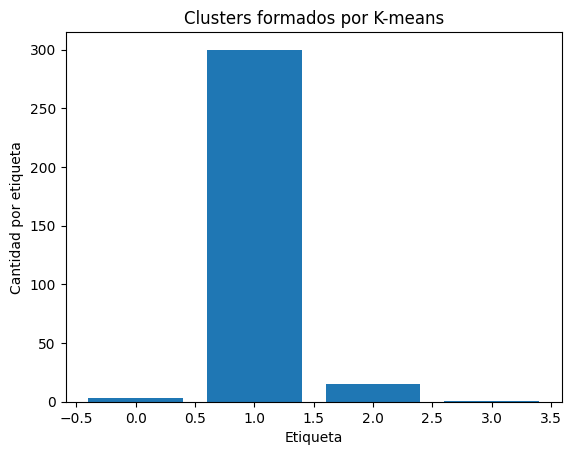

In [76]:
plt.bar(kmeans_df['Etiqueta K-means'], kmeans_df['Cantidad']) #gráfico considerando las etiquetas generadas por K-means y su cantidad
plt.xlabel("Etiqueta")
plt.ylabel("Cantidad por etiqueta")
plt.title("Clusters formados por K-means")
plt.show()

El número óptimo de clusters es igual a cuatro, mientras que el número óptimo de tópicos es dos.
Revisando la cantidad de vectores por cluster, solamente se justificaría la existencia del cluster 1 (300 tokens) y el cluster 2 (15 tokens), ya que un tópico con un solo token y otro con tres tokens tendría muy poca información para etiquetarlo adecuadamente.

Por este motivo considero que la partición creada por LDA tiene más sentido que la creada por K-means.

### Conclusiones

El diagnóstico de tópicos y etiquetado requiere de una limpieza previa del documento, verificando si las palabras aportan al contexto estudiado.
Es importante realizar un análisis previo mediante la propuesta de un número arbritrario de tópicos, análisis de coherencia y perplexity para corroborar el número óptimo de tópicos y finalmente revisar las palabras FREX para etiquetar cada tópico de forma adecuada.

K-means es una alternativa para detectar clusters, pero en este caso no resultó ser un algoritmo adecuado para particionar los documentos,